In [51]:
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from numpy import trapz

In [53]:
def pltROCnAUC(counts, bins, label): 
    x=[]
    y=[]
    for i in range(len(counts[0])):
        p = 0
        n = 0
        for j in range(i,len(counts[0])):
            p = p + counts[0][j]*(bins[j+1]-bins[j])
            n = n + counts[1][j]*(bins[j+1]-bins[j])
        x.append(p)
        y.append(n)
    AUC=trapz(x,y)
    #print(x)
    #print(y)
    plt.plot(y,x,label=label)
    plt.legend()
    return AUC

In [2]:
data = pd.read_json("datasetTest100k.json", typ="frame", lines = True, precise_float=True,nrows = 5*100000)

In [3]:
#from RealisticDataExplorer.ipynb
trkData = np.stack(data[3],axis=0)

trk_high_level_name = ["track_2_d0_significance", "track_3_d0_significance",
                       "track_2_z0_significance", "track_3_z0_significance",
                       "n_tracks_over_d0_threshold", "jet_prob", "jet_width_eta", "jet_width_phi"]

for i, trkName in enumerate(trk_high_level_name):
    tmpArr = np.array(trkData[:,i],dtype="float32")
    data[trkName] = tmpArr

vtxData = np.stack(data[4],axis=0)
    
vtx_high_level_name = ["vertex_significance", "n_secondary_vertices", "n_secondary_vertex_tracks",
                       "delta_r_vertex", "vertex_mass", "vertex_energy_fraction"]

for i, vtxName in enumerate(vtx_high_level_name):
    tmpArr = np.array(vtxData[:,i],dtype="float32")
    data[vtxName] = tmpArr

In [4]:
data

,0,1,2,3,4,5,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction
0,47.8712,1.893250,5,"[21.1765, 8.36586, 29.0269, 4.149, 5, 2.68624e...","[32.8902, 3, 7, 0.162448, 1.59408, 0.862678]","[[[0.0311627, 0.0820037, 0.0714865, 0.0122187,...",21.176500,8.365860,29.026899,4.149000,5.0,2.686240e-11,0.059397,0.060374,32.890202,3.0,7.0,0.162448,1.594080,0.862678
1,34.9703,0.609755,5,"[5.0077, 3.03583, 2.00754, 0.329921, 3, 1.7627...","[25.1935, 1, 3, 0.122343, 2.23962, 0.930327]","[[[-0.0290837, 0.122745, 0.311415, 0.054644, -...",5.007700,3.035830,2.007540,0.329921,3.0,1.762730e-05,0.066609,0.149812,25.193501,1.0,3.0,0.122343,2.239620,0.930327
2,26.5706,-0.530268,5,"[0.807884, 0.630565, 1.04452, 1.28336, 0, 0.04...","[-1, -1, -1, inf, -1, -inf]","[[[-0.00689455, -0.379085, 0.0617111, -0.02322...",0.807884,0.630565,1.044520,1.283360,0.0,4.808580e-02,0.097381,0.113961,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
3,36.9246,-2.074420,5,"[16.5617, 10.357, 17.5166, 30.4992, 4, 4.35319...","[73.6335, 1, 2, 0.259107, 0.755648, 0.594634]","[[[0.0183914, -0.00212568, -0.0371647, -0.0217...",16.561701,10.357000,17.516600,30.499201,4.0,4.353190e-10,0.162495,0.115695,73.633499,1.0,2.0,0.259107,0.755648,0.594634
4,28.9667,1.512090,5,"[18.0325, 16.1445, 3.29359, 9.00347, 4, 3.3143...","[293.79, 1, 4, 0.0871323, 1.40008, 1.00014]","[[[-0.753196, 3.5972, -0.11093, 0.0896224, -0....",18.032499,16.144501,3.293590,9.003470,4.0,3.314360e-11,0.088521,0.093888,293.790009,1.0,4.0,0.087132,1.400080,1.000140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,27.9514,-1.952300,0,"[0.594449, -inf, 0.17506, -inf, 0, 0.0520256, ...","[-1, -1, -1, inf, -1, -inf]","[[[0.0148769, -0.0165837, 0.0171593, 0.0010783...",0.594449,-inf,0.175060,-inf,0.0,5.202560e-02,0.124974,0.119607,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
199996,31.7411,0.581113,0,"[0.884008, 0.0586451, 2.08934, 1.0856, 1, 4.22...","[-1, -1, -1, inf, -1, -inf]","[[[-0.00236544, 0.264679, 0.0364315, 0.115328,...",0.884008,0.058645,2.089340,1.085600,1.0,4.225840e-05,0.128962,0.088855,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
199997,43.4182,-1.354190,0,"[2.01423, 0.0571862, 0.018169, 0.646206, 2, 0....","[-1, -1, -1, inf, -1, -inf]","[[[-0.0641859, -0.00209336, -0.0657659, -0.005...",2.014230,0.057186,0.018169,0.646206,2.0,1.049350e-02,0.110870,0.065049,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
199998,25.8566,-2.288910,0,"[1.1272, 0.794378, 0.415697, 0.0726794, 0, 0.0...","[-1, -1, -1, inf, -1, -inf]","[[[-0.0150902, 0.204454, -0.3825, -0.0139872, ...",1.127200,0.794378,0.415697,0.072679,0.0,1.737710e-02,0.077444,0.083011,-1.000000,-1.0,-1.0,inf,-1.000000,-inf


In [5]:
y = data[2]
y = y.values.tolist()

for i in range(len(y)):
    if y[i]==5:
        y[i]=1
    else:
        y[i]=0

In [80]:
jets_trk = []
for i in range(0,200000):
    trkVars = []
    for j in range(len(data[5][i])):
        trkVars.append(data[5][i][j][0])
    jets_trk.append(trkVars)

In [81]:
d0 = []
for i in jets_trk:
    temp = []
    for j in i:
        temp.append(j[0])
    d0.append(temp)

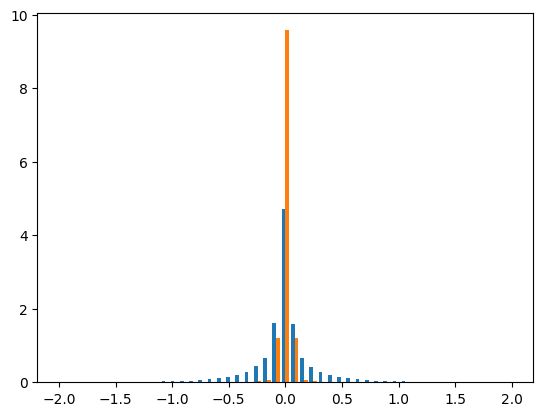

In [8]:
bj=[]
lf=[]
for i in range(len(y)):
    assert len(d0)==len(y)
    if y[i]==1:
        bj.append(d0[i])
    else:
        assert y[i]==0
        lf.append(d0[i])

def flatten(inData): 
    dataFlat = np.array([])
    for jet in inData:
        dataFlat = np.append(dataFlat,jet)
    return dataFlat
bj_d0_flat = flatten(bj)
lf_d0_flat = flatten(lf)
counts, bins, _ = plt.hist([bj_d0_flat,lf_d0_flat], bins=np.linspace(-2,2,50),density=True)

In [9]:
def probInHist(d0, counts, bins): #counts is list of lists
    x=len(bins)-2
    for i in range(len(bins)): 
        if d0 < bins[i]:
            x=i-1
            break
    p=(counts[0][x])/(counts[1][x])
    return p

def likelihood(test, train_hist_counts, train_hist_bins):
    p=[]
    for i in test:
        pi=1
        for j in i:
            pi = pi*probInHist(j,train_hist_counts, train_hist_bins)
        p.append(pi) 
    return p

bj_2d = copy.deepcopy(bj)
lf_2d = copy.deepcopy(lf)

for i in bj_2d:
    while len(i)>2:
        i.remove(min(i))
    while len(i)<2:
        i.append(0)

for i in lf_2d:
    while len(i)>2:
        i.remove(min(i))
    while len(i)<2:
        i.append(0)

res_b = likelihood(bj_2d,counts,bins)
res_lf = likelihood(lf_2d,counts,bins)


(array([[0.0000e+00, 1.9513e+04, 0.0000e+00, 1.4356e+04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 8.4410e+03, 0.0000e+00,
         1.5200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.9000e+01, 0.0000e+00, 3.5000e+01, 2.0000e+00, 0.0000e+00,
         2.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00, 2.1000e+01,
         7.5000e+01, 0.0000e+00, 1.7400e+02, 0.0000e+00, 4.3000e+02,
         3.3150e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.0000e+00, 3.3000e+01, 7.1000e+01,
         3.0000e+00, 1.1000e+02, 1.8630e+03, 4.8000e+01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.5200e+02, 4.2614e+04],
        [0.0000e+00, 7.2030e+04, 0.0000e+00, 2.5194e+04, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2400e+03, 0.0000e+00,
         2.3600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0000e+01, 0.0000e+00, 2.7000e+01, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 

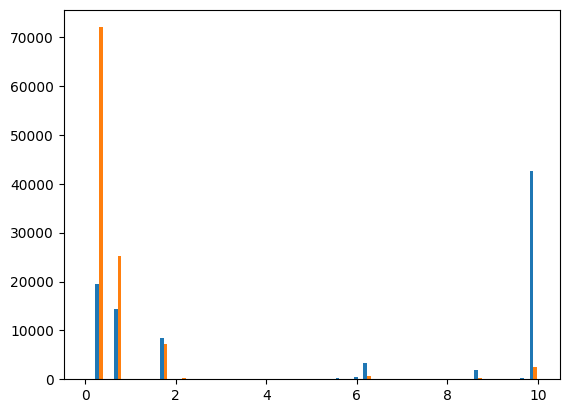

In [10]:
for i in range(len(res_b)):
    if res_b[i]>10:
        res_b[i]=10

for i in range(len(res_lf)):
    if res_lf[i]>10:
        res_lf[i]=10
        
plt.hist([res_b,res_lf],bins=np.linspace(0,10,50))

In [11]:
#shuffle
Xzip = list(zip(y,d0))
random.shuffle(Xzip)
y, d0 = list(zip(*Xzip))
#padding
for i in d0:
    while len(i)<5:
        i.append(-99)
    while len(i)>5:
        i.remove(min(i))
#picking out training and test data
y_train = y[0:160000]
y_test = y[160000:200000]
d0_train = d0[0:160000]
d0_test = d0[160000:200000]

d0_train = torch.tensor(d0_train,dtype=torch.float32)
d0_test = torch.tensor(d0_test,dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [12]:

simpleModel = nn.Sequential(
   nn.Linear(5,10),
   nn.Sigmoid(),
   nn.Linear(10,7),
   nn.Sigmoid(),
   nn.Linear(7,5),
   nn.Sigmoid(),
   nn.Linear(5,3),
   nn.Sigmoid(),
   nn.Linear(3,2),
   nn.Sigmoid(),
   nn.Linear(2,1),
   nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer=optim.Adam(simpleModel.parameters(),lr = 0.01)

In [57]:
n_epochs = 100
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(d0_train), batch_size):
        Xbatch = d0_train[i:i+batch_size]
        y_pred = simpleModel(Xbatch)
        ybatch = y_train[i:i+batch_size]
        #print(y_pred[0], ybatch[0])
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.5361019968986511
Finished epoch 1, latest loss 0.5211737155914307
Finished epoch 2, latest loss 0.5122111439704895
Finished epoch 3, latest loss 0.4598667025566101
Finished epoch 4, latest loss 0.47140204906463623
Finished epoch 5, latest loss 0.469786673784256
Finished epoch 6, latest loss 0.46808382868766785
Finished epoch 7, latest loss 0.4665636420249939
Finished epoch 8, latest loss 0.4678177535533905
Finished epoch 9, latest loss 0.46684566140174866
Finished epoch 10, latest loss 0.46931207180023193
Finished epoch 11, latest loss 0.46830978989601135
Finished epoch 12, latest loss 0.4676242172718048
Finished epoch 13, latest loss 0.46424809098243713
Finished epoch 14, latest loss 0.46199658513069153
Finished epoch 15, latest loss 0.45757487416267395
Finished epoch 16, latest loss 0.4426470994949341
Finished epoch 17, latest loss 0.45404183864593506
Finished epoch 18, latest loss 0.45741376280784607
Finished epoch 19, latest loss 0.45525142550468445


Accuracy 0.7738249897956848


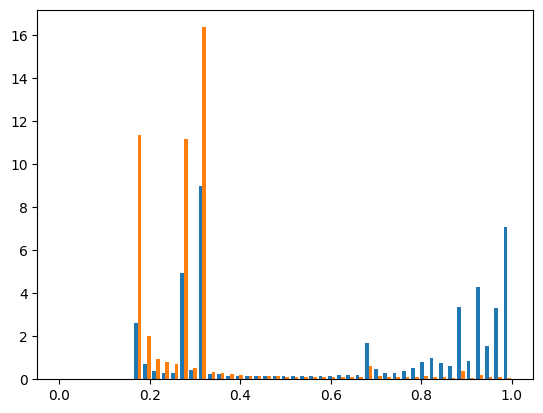

In [58]:
with torch.no_grad():
    y_pred = simpleModel(d0_test)
    #print(y_pred)
accuracy = (y_pred.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

true=[]
false=[]
y_pred=torch.flatten(y_pred)
y_pred=y_pred.tolist()
for i in range(len(y_test)):
    if y_test[i]==1:
        true.append(y_pred[i])
    else:
        false.append(y_pred[i])
d0Counts,d0bins, _=plt.hist([true,false], bins=np.linspace(0,1,50), density=True)

In [34]:
data

,0,1,2,3,4,5,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold,jet_prob,jet_width_eta,jet_width_phi,vertex_significance,n_secondary_vertices,n_secondary_vertex_tracks,delta_r_vertex,vertex_mass,vertex_energy_fraction
0,47.8712,1.893250,5,"[21.1765, 8.36586, 29.0269, 4.149, 5, 2.68624e...","[32.8902, 3, 7, 0.162448, 1.59408, 0.862678]","[[[0.0311627, 0.0820037, 0.0714865, 0.0122187,...",21.176500,8.365860,29.026899,4.149000,5.0,2.686240e-11,0.059397,0.060374,32.890202,3.0,7.0,0.162448,1.594080,0.862678
1,34.9703,0.609755,5,"[5.0077, 3.03583, 2.00754, 0.329921, 3, 1.7627...","[25.1935, 1, 3, 0.122343, 2.23962, 0.930327]","[[[-0.0290837, 0.122745, 0.311415, 0.054644, -...",5.007700,3.035830,2.007540,0.329921,3.0,1.762730e-05,0.066609,0.149812,25.193501,1.0,3.0,0.122343,2.239620,0.930327
2,26.5706,-0.530268,5,"[0.807884, 0.630565, 1.04452, 1.28336, 0, 0.04...","[-1, -1, -1, inf, -1, -inf]","[[[-0.00689455, -0.379085, 0.0617111, -0.02322...",0.807884,0.630565,1.044520,1.283360,0.0,4.808580e-02,0.097381,0.113961,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
3,36.9246,-2.074420,5,"[16.5617, 10.357, 17.5166, 30.4992, 4, 4.35319...","[73.6335, 1, 2, 0.259107, 0.755648, 0.594634]","[[[0.0183914, -0.00212568, -0.0371647, -0.0217...",16.561701,10.357000,17.516600,30.499201,4.0,4.353190e-10,0.162495,0.115695,73.633499,1.0,2.0,0.259107,0.755648,0.594634
4,28.9667,1.512090,5,"[18.0325, 16.1445, 3.29359, 9.00347, 4, 3.3143...","[293.79, 1, 4, 0.0871323, 1.40008, 1.00014]","[[[-0.753196, 3.5972, -0.11093, 0.0896224, -0....",18.032499,16.144501,3.293590,9.003470,4.0,3.314360e-11,0.088521,0.093888,293.790009,1.0,4.0,0.087132,1.400080,1.000140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,27.9514,-1.952300,0,"[0.594449, -inf, 0.17506, -inf, 0, 0.0520256, ...","[-1, -1, -1, inf, -1, -inf]","[[[0.0148769, -0.0165837, 0.0171593, 0.0010783...",0.594449,-inf,0.175060,-inf,0.0,5.202560e-02,0.124974,0.119607,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
199996,31.7411,0.581113,0,"[0.884008, 0.0586451, 2.08934, 1.0856, 1, 4.22...","[-1, -1, -1, inf, -1, -inf]","[[[-0.00236544, 0.264679, 0.0364315, 0.115328,...",0.884008,0.058645,2.089340,1.085600,1.0,4.225840e-05,0.128962,0.088855,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
199997,43.4182,-1.354190,0,"[2.01423, 0.0571862, 0.018169, 0.646206, 2, 0....","[-1, -1, -1, inf, -1, -inf]","[[[-0.0641859, -0.00209336, -0.0657659, -0.005...",2.014230,0.057186,0.018169,0.646206,2.0,1.049350e-02,0.110870,0.065049,-1.000000,-1.0,-1.0,inf,-1.000000,-inf
199998,25.8566,-2.288910,0,"[1.1272, 0.794378, 0.415697, 0.0726794, 0, 0.0...","[-1, -1, -1, inf, -1, -inf]","[[[-0.0150902, 0.204454, -0.3825, -0.0139872, ...",1.127200,0.794378,0.415697,0.072679,0.0,1.737710e-02,0.077444,0.083011,-1.000000,-1.0,-1.0,inf,-1.000000,-inf


In [35]:
high_lev_data = data.loc[:,'track_2_d0_significance' : 'n_tracks_over_d0_threshold']

In [36]:
high_lev_data

,track_2_d0_significance,track_3_d0_significance,track_2_z0_significance,track_3_z0_significance,n_tracks_over_d0_threshold
0,21.176500,8.365860,29.026899,4.149000,5.0
1,5.007700,3.035830,2.007540,0.329921,3.0
2,0.807884,0.630565,1.044520,1.283360,0.0
3,16.561701,10.357000,17.516600,30.499201,4.0
4,18.032499,16.144501,3.293590,9.003470,4.0
...,...,...,...,...,...
199995,0.594449,-inf,0.175060,-inf,0.0
199996,0.884008,0.058645,2.089340,1.085600,1.0
199997,2.014230,0.057186,0.018169,0.646206,2.0
199998,1.127200,0.794378,0.415697,0.072679,0.0


In [37]:
no_inf = data[high_lev_data["track_2_d0_significance"] != (-np.inf or np.inf)]
#infs = data[data["track_2_d0_significance"] == (-np.inf or np.inf)]
no_inf = no_inf[no_inf["track_3_d0_significance"] != (-np.inf or np.inf)]
no_inf = no_inf[no_inf["track_2_z0_significance"] != (-np.inf or np.inf)]
no_inf = no_inf[no_inf["track_3_z0_significance"] != (-np.inf or np.inf)]
print(no_inf.shape)
#print(infs.shape)

(154644, 20)


In [38]:
high_lev_y = no_inf[2]
high_lev_y = high_lev_y.values.tolist()
for i in range(len(high_lev_y)):
    if high_lev_y[i]==5:
        high_lev_y[i]=1
    else:
        high_lev_y[i]=0

high_lev_x = no_inf[3]
high_lev_x = high_lev_x.values.tolist()
for i in high_lev_x:
    i.pop(-1)
    i.pop(-1)
    i.pop(-1)


In [39]:
high_level_vars_zip = list(zip(high_lev_y,high_lev_x))
random.shuffle(high_level_vars_zip)
high_lev_y, high_lev_x = list(zip(*high_level_vars_zip))

high_lev_x_train = high_lev_x[0:100000]
high_lev_x_test = high_lev_x[100000:len(high_lev_x)]
high_lev_y_train = high_lev_y[0:100000]
high_lev_y_test = high_lev_y[100000:len(high_lev_y)]

highlevelTest_b=[]
highlevelTest_lf=[]

for i in range(len(high_lev_y_test)):
    if high_lev_y_test[i]==1:
        highlevelTest_b.append(high_lev_x_test[i])
    else:
        highlevelTest_lf.append(high_lev_x_test[i])

highlevelTest_b = torch.tensor(highlevelTest_b, dtype=torch.float32)
highlevelTest_lf = torch.tensor(highlevelTest_lf, dtype=torch.float32)

In [40]:
high_lev_y_train = torch.tensor(high_lev_y, dtype=torch.float32).reshape(-1, 1)
high_lev_y_test = torch.tensor(high_lev_y, dtype=torch.float32).reshape(-1, 1)
high_lev_x_train = torch.tensor(high_lev_x, dtype=torch.float32)
high_lev_x_test = torch.tensor(high_lev_x, dtype=torch.float32)

In [41]:
n_epochs = 100
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(high_lev_x_train), batch_size):
        Xbatch = high_lev_x_train[i:i+batch_size]
        y_pred = simpleModel(Xbatch)
        ybatch = high_lev_y_train[i:i+batch_size]
        #print(y_pred[0], ybatch[0])
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

with torch.no_grad():
    y_pred = simpleModel(high_lev_x_test)
    print(y_pred)
accuracy = (y_pred.round() == high_lev_y_test).float().mean()
print(f"Accuracy {accuracy}")

Finished epoch 0, latest loss 0.5168104767799377
Finished epoch 1, latest loss 0.42471742630004883
Finished epoch 2, latest loss 0.4074763357639313
Finished epoch 3, latest loss 0.38387709856033325
Finished epoch 4, latest loss 0.3868879973888397
Finished epoch 5, latest loss 0.3824023902416229
Finished epoch 6, latest loss 0.3806953728199005
Finished epoch 7, latest loss 0.3815933167934418
Finished epoch 8, latest loss 0.398082435131073
Finished epoch 9, latest loss 0.39598333835601807
Finished epoch 10, latest loss 0.3819439709186554
Finished epoch 11, latest loss 0.38382065296173096
Finished epoch 12, latest loss 0.38478338718414307
Finished epoch 13, latest loss 0.3805104196071625
Finished epoch 14, latest loss 0.38435888290405273
Finished epoch 15, latest loss 0.38252466917037964
Finished epoch 16, latest loss 0.38165998458862305
Finished epoch 17, latest loss 0.37687501311302185
Finished epoch 18, latest loss 0.38895806670188904
Finished epoch 19, latest loss 0.37500208616256714


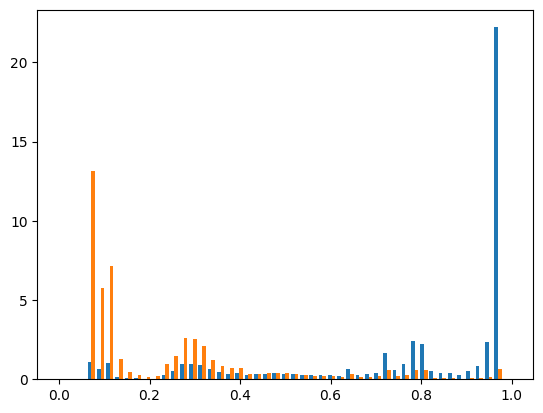

In [49]:
true = simpleModel(highlevelTest_b)
true=torch.flatten(true).tolist()
false = simpleModel(highlevelTest_lf)
false=torch.flatten(false).tolist()

hlCounts,hlbins,_=plt.hist([true,false], bins=np.linspace(0,1,50), density=True)

0.9034417997271701
0.8063822942592624


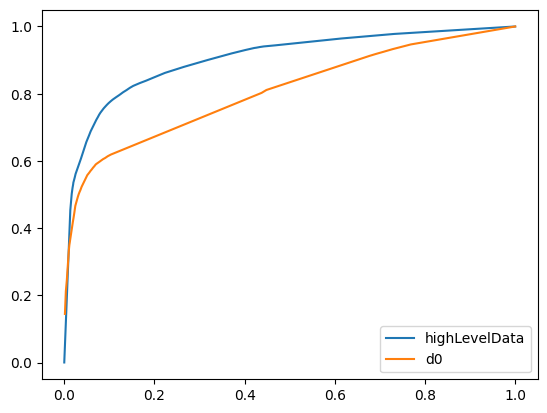

In [61]:
aucHL=pltROCnAUC(hlCounts,hlbins,"highLevelData")
aucd0=pltROCnAUC(d0Counts,d0bins,"d0")

print(-aucHL)
print(-aucd0)

In [117]:
#num_tracks=[]
#for i in jets_trk:
    #num_tracks.append(len(i))
#plt.hist(num_tracks,np.linspace(0,23,24))
for i in jets_trk:
    i.sort(key=lambda x : x[0],reverse=True)
temp=[-99,-99,-99,-99,-99]
for i in jets_trk:
    while len(i)<15:
        i.append(temp)
    while len(i)>15:
        i.pop(len(i)-1)

In [118]:
jets_trk_x=torch.tensor(jets_trk,dtype=torch.float32)
jets_trk_x=jets_trk_x.flatten(start_dim=1)
jets_trk_x=jets_trk_x.tolist()

In [119]:
jets_trk_y=data[2]
jets_trk_y=jets_trk_y.values.tolist()
for i in range(len(jets_trk_y)):
    if jets_trk_y[i]==5:
        jets_trk_y[i]=1
    else:
        jets_trk_y[i]=0

zipp = list(zip(jets_trk_y,jets_trk_x))
random.shuffle(zipp)
jets_trk_y, jets_trk_x = list(zip(*zipp))

jets_trk_x

([0.05458509922027588,
  -0.4352779984474182,
  -0.009494819678366184,
  -0.2378380000591278,
  0.35770100355148315,
  -0.0010679500410333276,
  0.1366640031337738,
  0.2007090002298355,
  -0.02616179920732975,
  1.413640022277832,
  -0.01905130036175251,
  -0.44840699434280396,
  -0.10219600051641464,
  0.10187900066375732,
  -0.3596709966659546,
  -0.03240939974784851,
  -0.6142110228538513,
  -0.01629829965531826,
  -0.01442319992929697,
  -0.7517139911651611,
  -0.052838001400232315,
  0.6164590120315552,
  0.046042099595069885,
  -0.1064469963312149,
  -0.5648189783096313,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
  -99.0,
 

In [120]:
jets_trk_y

(0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,


In [121]:
jets_trk_x=torch.tensor(jets_trk_x,dtype=torch.float32)
jets_trk_y=torch.tensor(jets_trk_y,dtype=torch.float32).reshape(-1,1)

In [136]:
feedForwardModel = nn.Sequential(
    nn.Linear(75,50),
    nn.Sigmoid(),
    nn.Linear(50,30),
    nn.Sigmoid(),
    nn.Linear(30,10),
    nn.Sigmoid(),
    nn.Linear(10,1),
    nn.Sigmoid(),
)
loss_fn = nn.BCELoss()
optimizer=optim.Adam(feedForwardModel.parameters(),lr = 0.01)

In [137]:
n_epochs = 100
batch_size = 100
 
for epoch in range(n_epochs):
    for i in range(0, len(jets_trk_x), batch_size):
        Xbatch = jets_trk_x[i:i+batch_size]
        y_pred = feedForwardModel(Xbatch)
        ybatch = jets_trk_y[i:i+batch_size]
        #print(y_pred[0], ybatch[0])
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

with torch.no_grad():
    y_pred = feedForwardModel(jets_trk_x)
    print(y_pred)
accuracy = (y_pred.round() == jets_trk_y).float().mean()
print(f"Accuracy {accuracy}")

Finished epoch 0, latest loss 0.6764495372772217
Finished epoch 1, latest loss 0.6755779981613159
Finished epoch 2, latest loss 0.6443953514099121
Finished epoch 3, latest loss 0.6445268392562866
Finished epoch 4, latest loss 0.6490304470062256
Finished epoch 5, latest loss 0.6284298896789551
Finished epoch 6, latest loss 0.6332309246063232
Finished epoch 7, latest loss 0.6355642080307007
Finished epoch 8, latest loss 0.6476361155509949
Finished epoch 9, latest loss 0.6366882920265198
Finished epoch 10, latest loss 0.6403210163116455
Finished epoch 11, latest loss 0.6410582065582275
Finished epoch 12, latest loss 0.6325300335884094
Finished epoch 13, latest loss 0.6313729286193848
Finished epoch 14, latest loss 0.6347123980522156
Finished epoch 15, latest loss 0.6285097599029541
Finished epoch 16, latest loss 0.6276490092277527
Finished epoch 17, latest loss 0.6279714703559875
Finished epoch 18, latest loss 0.628107488155365
Finished epoch 19, latest loss 0.6285257935523987
Finished ep